In [2]:
import numpy as np
import matplotlib.pyplot as plt

size = 300
c_x = 150
c_y = 150
r = 120

In [3]:
# Wikipedia algorithm: https://en.wikipedia.org/wiki/Midpoint_circle_algorithm#C_example
canvas = np.zeros((size,size))
x = r - 1
y = 0
dx = 1
dy = 1
err = dx - (r << 1)
while x > y:
    canvas[c_x + x, c_y + y] = 1
    canvas[c_x + y, c_y + x] = 1
    canvas[c_x - y, c_y + x] = 1
    canvas[c_x - x, c_y + y] = 1
    canvas[c_x - x, c_y - y] = 1
    canvas[c_x - y, c_y - x] = 1
    canvas[c_x + y, c_y - x] = 1
    canvas[c_x + x, c_y - y] = 1
    
    if err <= 0:
        y += 1
        err += dy
        dy += 2
    if err > 0:
        x -= 1
        dx += 2
        err += dx - (r << 1)

In [4]:
for x in range(size):
    first_y = -1
    last_y = -1
    started = False
    for y in range(size):
        if canvas[x][y] == 1 and not started:
            first_y = y + 1
            started = True
        elif canvas[x][y] == 1 and started:
            last_y = y - 1
    canvas[x][first_y:last_y+1] = 1

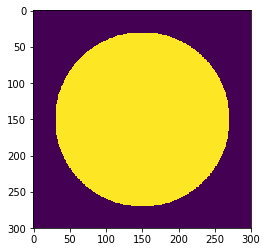

In [5]:
plt.imshow(canvas)
plt.show()

In [6]:
density = np.flipud(np.load('square_density.npy'))

/Users/pjrule/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


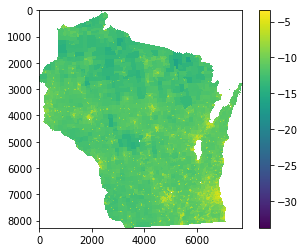

In [8]:

plt.imshow(np.log(density))
plt.colorbar()
plt.show()

In [212]:
from math import floor, ceil
from numba import jit

@jit # for a magical ~1000x speedup! 
def local_density(x, y, r):
    min_x = floor(x - r)
    max_x = ceil(x + r)
    min_y = floor(y - r)
    max_y = ceil(y + r)
    
    bounded = density[min_x:max_x,min_y:max_y]
    mask = np.zeros_like(bounded)
    c_x = round((max_x - min_x) / 2)
    c_y = round((max_y - min_y) / 2)
    
    # Wikipedia algorithm: https://en.wikipedia.org/wiki/Midpoint_circle_algorithm#C_example
    x = r - 1
    y = 0
    dx = 1
    dy = 1
    err = dx - (r << 1)
    while x > y:
        mask[c_x + x, c_y + y] = 1
        mask[c_x + y, c_y + x] = 10
        mask[c_x - y, c_y + x] = 1
        mask[c_x - x, c_y + y] = 1
        mask[c_x - x, c_y - y] = 1
        mask[c_x - y, c_y - x] = 1
        mask[c_x + y, c_y - x] = 1
        mask[c_x + x, c_y - y] = 1

        if err <= 0:
            y += 1
            err += dy
            dy += 2
        if err > 0:
            x -= 1
            dx += 2
            err += dx - (r << 1)
            
    # scanline fill
    masked = 0
    for x in range(mask.shape[0]):
        first_y = -1
        last_y = -1
        started = False
        for y in range(mask.shape[1]):
            if mask[x][y] == 1 and not started:
                first_y = y + 1
                started = True
            elif mask[x][y] == 1 and started:
                last_y = y - 1
        mask[x][first_y:last_y+1] = 1
        masked += (last_y - first_y + 1)
        
    # TODO: fix mask
    return np.sum(mask*bounded) / masked * (np.pi * r * r) # * some big scale factor to get things in the right units

In [213]:
%timeit local_density(4000, 4000, 100)

170 µs ± 24.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [2]:
density.max()

NameError: name 'density' is not defined